In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(precision=2) 
np.set_printoptions(linewidth=160)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w", 'bbox_inches': 'tight'}
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import shutil

# find the path to pdflatex executable
pdflatex_path = shutil.which("pdflatex")

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 16,  # default for all
    "axes.titlesize": 20,  # fontsize of the axes title
    "axes.labelsize": 18,  # fontsize of the x and y labels
    "xtick.labelsize": 16,  # fontsize of the tick labels
    "ytick.labelsize": 16,  # fontsize of the tick labels
})



In [2]:
import json
import glob
import os

# Function to load data from a JSON file
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Assuming all files are in the current directory, adjust the path if necessary
path_to_files = './results'  # Adjust this path if your files are in a different directory
file_pattern = os.path.join(path_to_files, 'results_*.json')
files = sorted(glob.glob(file_pattern))

# Initialize a dictionary to hold the combined data
results = {}

# Loop through the files and combine data based on constraints and facilities
for file in files:
    # Extract the number of constraints and facilities from the file name
    parts = os.path.basename(file).split('_')
    constraints = parts[1]
    facilities = parts[5]
    # Correcting the key to include both constraints and the number of facilities
    key = f"{constraints}-{facilities.split('_')[0]}"  # Adjusted to extract correct facility number

    # Load data from the current file
    data = load_json_data(file)
    
    # Combine data under the correct keys
    if key not in results:
        results[key] = []
    results[key].extend(data if isinstance(data, list) else [data])

def concatenate_dicts(dict_list):
    """
    Concatenate a list of dictionaries with the same fields into a single dictionary.
    """
    concatenated_dict = {key: [] for key in dict_list[0]}
    for d in dict_list:
        for key, value in d.items():
            concatenated_dict[key].extend(value)
    return concatenated_dict

for key in results:
    results[key] = concatenate_dicts(results[key])
    
# Now, `results` contains the combined data for each constraint-facility combination
# with corrected keys like '30-10', '60-30', '90-60', etc.


We are attempting to take a median value of a result over N function evaluations, but evaluations are taken a batch at a time and the batch changes.

The goal is to convert every run into a vector of length N so they can all be compared and summarized.

The total function evals can be found like this: `max(results['30-10']['fevals'])`

the 'x-value' of a single line can be found like this:
results`['30-10']['evaluations_per_generation'][0]`

the 'y-value' of that line can be found like this
`results['30-10']['best_objective_per_generation'][0]`

The goal is to map this to a vector of length N, repeating the previous 'best' until the next 'evaluations_per_generation'

for example:

evals: `1, 5, 10`

best: `2, 4, 7`

best_per_eval: `2,2,2,2,2,4,4,4,4,7`

if the number of evaluations is less than the total function evals, repeat the final best value to the end of the vector.

In [3]:
import numpy as np

def get_best_per_eval(results, key, list_index, N):
    evals = results[key]['evaluations_per_generation'][list_index]
    best = results[key]['best_objective_per_generation'][list_index]
    best_per_eval = [np.nan] * N
    first_eval = evals[0] if evals else N  # Use N if evals is empty to handle edge cases
    current_best = None
    eval_index = 0

    for i in range(N):
        if i+1 < first_eval:
            continue
        if eval_index < len(evals) and i+1 >= evals[eval_index]:
            current_best = best[eval_index]
            eval_index += 1
        best_per_eval[i] = current_best if current_best is not None else best[-1] if best else np.nan
    
    if evals and evals[-1] < N:
        for i in range(evals[-1], N):
            best_per_eval[i] = best[-1] if best else np.nan
    
    return best_per_eval

# Loop through each top-level dictionary item and add the 'best_per_eval' field
for key in results.keys():
    N = max(results[key]['fevals'])  # Determine the length N for the current key
    list_length = len(results[key]['evaluations_per_generation'])  # Get the number of lists
    
    # Initialize a matrix for the current key
    matrix = np.empty((N, list_length))
    matrix[:] = np.nan  # Fill the matrix with nan
    
    # Populate the matrix with best_per_eval values for each list index
    for list_index in range(list_length):
        best_per_eval_vector = get_best_per_eval(results, key, list_index, N)
        matrix[:, list_index] = best_per_eval_vector  # Assign the vector to the matrix column
    
    # After populating the matrix for the current key, assign it back to results
    results[key]['best_per_eval_matrix'] = matrix

# At this point, each key in `results` has a 'best_per_eval_matrix' containing the best_per_eval vectors


In [4]:
# Visual Confirmation  # *** WARNING: DON'T DO THIS WITH 1000 lines per plot! *** #
# import matplotlib.pyplot as plt

# # Determine the number of subplots needed
# num_keys = len(results.keys())
# fig, axes = plt.subplots(num_keys, 1, figsize=(10, num_keys * 5))

# if num_keys == 1:
#     axes = [axes]  # Ensure axes is iterable for a single subplot case

# for ax, (key, data) in zip(axes, results.items()):
#     matrix = data['best_per_eval_matrix']
#     median_values = np.nanmedian(matrix, axis=1)
    
#     # Plot each line
#     for i in range(matrix.shape[1]):
#         ax.plot(matrix[:, i], label=f'Run {i+1}', alpha=0.5)
    
#     # Plot median
#     ax.plot(median_values, label='Median', color='black', linewidth=2)
    
#     ax.set_title(f'Key: {key}')
#     ax.set_xlabel('Evaluation')
#     ax.set_ylabel('Best Objective')
#     ax.legend()

# plt.tight_layout()
# plt.show()


/Users/gaiera/miniconda3/envs/plotmap/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/gaiera/miniconda3/envs/plotmap/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


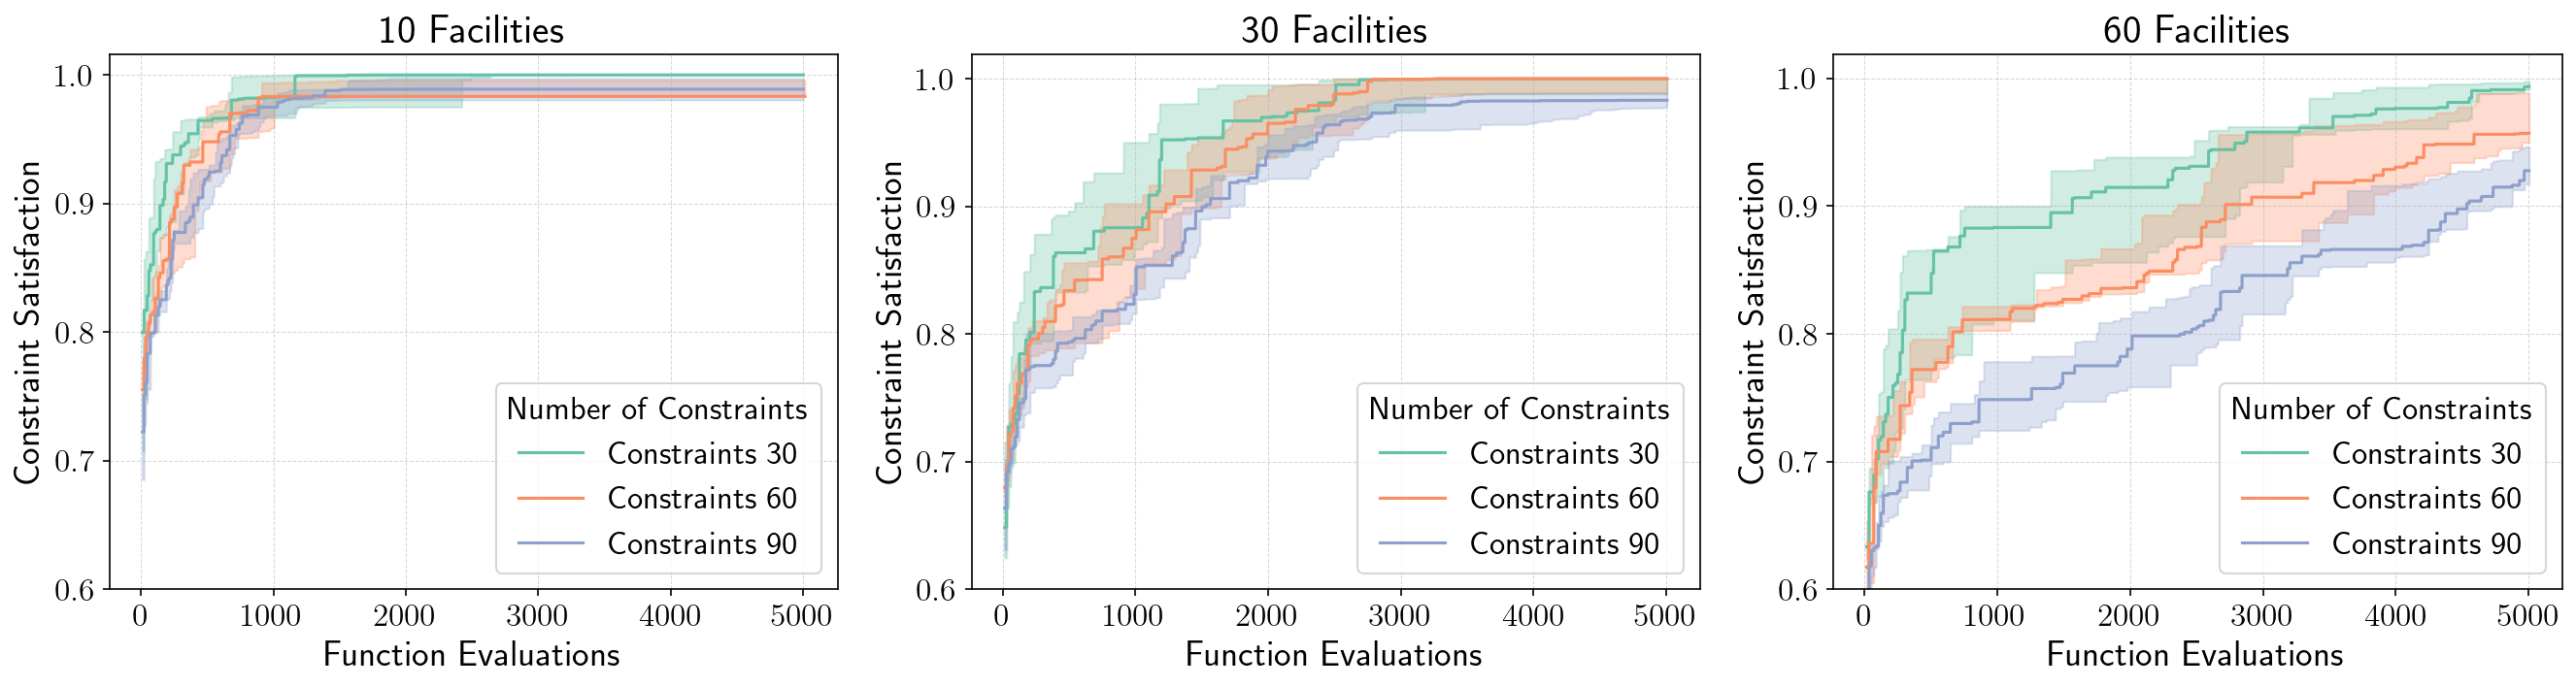

In [51]:
import matplotlib

def plot_convergence(ax, n_facilities, results):
    keys = [f'{n}-{n_facilities}' for n in ('30', '60', '90')]
    cmap = matplotlib.colormaps['Set2']  # Using the 'Set2' color palette
    labels = ['30', '60', '90']  # Labels for the legend

    for i, key in enumerate(keys):
        if key not in results:
            continue  # Skip if the key doesn't exist in results
        matrix = results[key]['best_per_eval_matrix']
        median_values = np.nanmedian(matrix, axis=1)
        lower_quartile = np.nanpercentile(matrix, 25, axis=1)
        upper_quartile = np.nanpercentile(matrix, 75, axis=1)

        # Plotting on given axis
        ax.plot(median_values, label=f'Constraints {labels[i]}', color=cmap(i))
        ax.fill_between(range(len(median_values)), lower_quartile, upper_quartile, color=cmap(i), alpha=0.3)

    ax.set_title(f'{n_facilities} Facilities')
    ax.set_xlabel('Function Evaluations')
    ax.set_ylabel('Constraint Satisfaction')
    ax.legend(title='Number of Constraints')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    if median_values.size > 0:  # Check if median_values is not empty
        #ax.set_xticks(range(0, len(median_values), max(1, len(median_values) // 10)))  # Adjust tick spacing
        ax.set_xticks(range(0, N + 1, 1000)) 
    ax.set_ylim([0.6, None])         

# Creating a plot with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(18, 5),dpi=150)  # Adjust figsize as needed

# Plotting each subplot
plot_convergence(axs[0], 10, results)
plot_convergence(axs[1], 30, results)
plot_convergence(axs[2], 60, results)

plt.tight_layout()  # Adjust layout to prevent overlap
#plt.savefig("convergance.pgf") # not with so many points...
#plt.savefig("convergance.pdf")
plt.savefig("convergance.png")
plt.show()


In [6]:
from scipy.stats import mannwhitneyu
from tabulate import tabulate

def get_final_values(results, key):
    if key in results and 'best_per_eval_matrix' in results[key]:
        matrix = results[key]['best_per_eval_matrix']
        # Extract non-NaN final values from the last evaluation
        return [matrix[-1, i] for i in range(matrix.shape[1]) if not np.isnan(matrix[-1, i])]
    return []


def print_p_value_table(results, facilities_list):
    for n_facilities in facilities_list:
        # Prepare data for table
        table_data = []
        headers = ["Comparison", "P-Value"]
        
        # Pairwise comparisons
        comparisons = [("30-10", "60-10"), ("60-10", "90-10"), ("30-10", "90-10")]
        for n1, n2 in comparisons:
            key1 = f"{n1.split('-')[0]}-{n_facilities}"
            key2 = f"{n2.split('-')[0]}-{n_facilities}"
            
            if key1 in results and key2 in results:
                final_values1 = get_final_values(results, key1)
                final_values2 = get_final_values(results, key2)
                _, p_value = mannwhitneyu(final_values1, final_values2, alternative='two-sided')
                table_data.append([f"{key1} vs. {key2}", f"{p_value:.4f}"])
            else:
                table_data.append([f"{key1} vs. {key2}", "N/A"])

        # Print the table
        print(f"P-Values for {n_facilities} Facilities")
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        print()  # For spacing between tables

# Example usage
facilities_list = [10, 30, 60]
print_p_value_table(results, facilities_list)



P-Values for 10 Facilities
+-----------------+-----------+
| Comparison      |   P-Value |
+=================+===========+
| 30-10 vs. 60-10 |    0.2946 |
+-----------------+-----------+
| 60-10 vs. 90-10 |    1      |
+-----------------+-----------+
| 30-10 vs. 90-10 |    0.0921 |
+-----------------+-----------+

P-Values for 30 Facilities
+-----------------+-----------+
| Comparison      |   P-Value |
+=================+===========+
| 30-30 vs. 60-30 |    0.8182 |
+-----------------+-----------+
| 60-30 vs. 90-30 |    0.3939 |
+-----------------+-----------+
| 30-30 vs. 90-30 |    0.3939 |
+-----------------+-----------+

P-Values for 60 Facilities
+-----------------+-----------+
| Comparison      |   P-Value |
+=================+===========+
| 30-60 vs. 60-60 |    0.2403 |
+-----------------+-----------+
| 60-60 vs. 90-60 |    0.0931 |
+-----------------+-----------+
| 30-60 vs. 90-60 |    0.0087 |
+-----------------+-----------+



In [7]:
# Iteration Time
# Computation time is saved as a cumulative sum, what we want is a median value of each timestep.
# let's first convert the the wall time to a time at each generation (subtracting from the previous step)
# and dump it into a bucket with all the other differences in that run. 
# Then lets take the mean and std deviation

import numpy as np

def calculate_iteration_times(results):
    table_data = []
    headers = ['Experiment', 'Mean Time per Generation (s)', 'Std Deviation (s)']
    
    for key in results.keys():
        # Retrieve cumulative wall times for all generations
        cumulative_times = results[key]['wall_time_per_generation']
        
        # Convert to per-generation times
        per_generation_times = [times[i] - times[i-1] for times in cumulative_times for i in range(1, len(times))]
        
        # Calculate mean and standard deviation
        mean_time = np.mean(per_generation_times)
        std_deviation = np.std(per_generation_times)
        
        table_data.append([key, f"{mean_time:.2f}", f"{std_deviation:.2f}"])
    
    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Assuming results is your data structure
calculate_iteration_times(results)


+--------------+--------------------------------+---------------------+
| Experiment   |   Mean Time per Generation (s) |   Std Deviation (s) |
+==============+================================+=====================+
| 30-10        |                           0.22 |                0.13 |
+--------------+--------------------------------+---------------------+
| 30-30        |                           0.37 |                0.14 |
+--------------+--------------------------------+---------------------+
| 30-60        |                           0.48 |                0.16 |
+--------------+--------------------------------+---------------------+
| 60-10        |                           0.36 |                0.17 |
+--------------+--------------------------------+---------------------+
| 60-30        |                           0.53 |                0.16 |
+--------------+--------------------------------+---------------------+
| 60-60        |                           0.64 |               

+--------------+-------------+-----------------+
| Experiment   |   Mean Time |   Std Deviation |
+==============+=============+=================+
| 30-10        |    0.254592 |        0.121477 |
+--------------+-------------+-----------------+
| 30-30        |    0.34992  |        0.171014 |
+--------------+-------------+-----------------+
| 30-60        |    0.51215  |        0.151076 |
+--------------+-------------+-----------------+
| 60-10        |    0.347631 |        0.128974 |
+--------------+-------------+-----------------+
| 60-30        |    0.525961 |        0.149976 |
+--------------+-------------+-----------------+
| 60-60        |    0.731362 |        0.214278 |
+--------------+-------------+-----------------+
| 90-10        |    0.599721 |        0.219687 |
+--------------+-------------+-----------------+
| 90-30        |    0.766545 |        0.236084 |
+--------------+-------------+-----------------+
| 90-60        |    0.903418 |        0.289648 |
+--------------+----

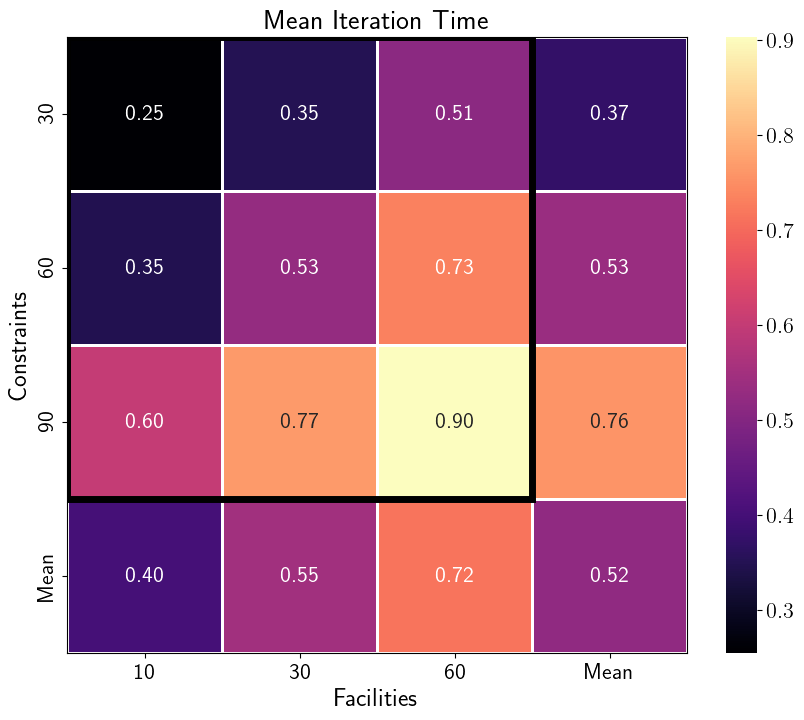

In [29]:
import numpy as np
from tabulate import tabulate
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def convert_to_generation_time(results):
    converted_results = {}  # Create a new dictionary to store converted times
    for key in results:
        wall_times = results[key]['wall_time_per_generation']
        converted_times = []  # Initialize a list to store converted times for the current key
        for gen_index in range(len(wall_times)):
            current_gen_times = wall_times[gen_index]
            # Compute the step times without altering the original list
            step_times = [current_gen_times[i] - current_gen_times[i-1] if i > 0 else current_gen_times[0] for i in range(len(current_gen_times))]
            # Take only the first 10 steps to avoid dealing with double pop
            step_times = step_times[:10]
            converted_times.append(step_times)
        # Add the converted times to the new dictionary
        converted_results[key] = {'wall_time_per_generation': converted_times}
    return converted_results

# Update calculate_mean_std to work with the new structure if necessary
def calculate_mean_std(converted_results):
    stats = {}
    for key in converted_results:
        all_gen_times = sum(converted_results[key]['wall_time_per_generation'], [])
        mean_time = np.mean(all_gen_times)
        std_deviation = np.std(all_gen_times)
        stats[key] = (mean_time, std_deviation)
    return stats


def generate_table(stats):
    table_data = []
    for key, (mean, std) in stats.items():
        table_data.append([key, mean, std])
    headers = ['Experiment', 'Mean Time', 'Std Deviation']
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

def create_heatmap(stats, constraints, facilities):
    data = np.zeros((len(constraints) + 1, len(facilities) + 1))
    for i, constraint in enumerate(constraints):
        for j, facility in enumerate(facilities):
            key = f"{constraint}-{facility}"
            if key in stats:
                data[i, j] = stats[key][0]
    data[-1, :-1] = np.mean(data[:-1, :-1], axis=0)
    data[:-1, -1] = np.mean(data[:-1, :-1], axis=1)
    data[-1,-1] = np.mean(data)
    
    df = pd.DataFrame(data, index=constraints+['Mean'], columns=facilities+['Mean'])
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="magma", linewidths=2, linecolor='white')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.add_patch(plt.Rectangle((0, 0), len(facilities), len(constraints), fill=False, edgecolor='black', lw=5))
    #ax.add_patch(plt.Rectangle((0, 0), len(facilities)+1, len(constraints)+1, fill=False, edgecolor='black', lw=3))
    plt.title('Mean Iteration Time')
    plt.xlabel('Facilities')
    plt.ylabel('Constraints')
    plt.show()

# Assuming results is already defined
converted_results = convert_to_generation_time(results)
stats = calculate_mean_std(converted_results)
generate_table(stats)
constraints = ['30', '60', '90']
facilities = ['10', '30', '60']
create_heatmap(stats, constraints, facilities)


/Users/gaiera/miniconda3/envs/plotmap/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/gaiera/miniconda3/envs/plotmap/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


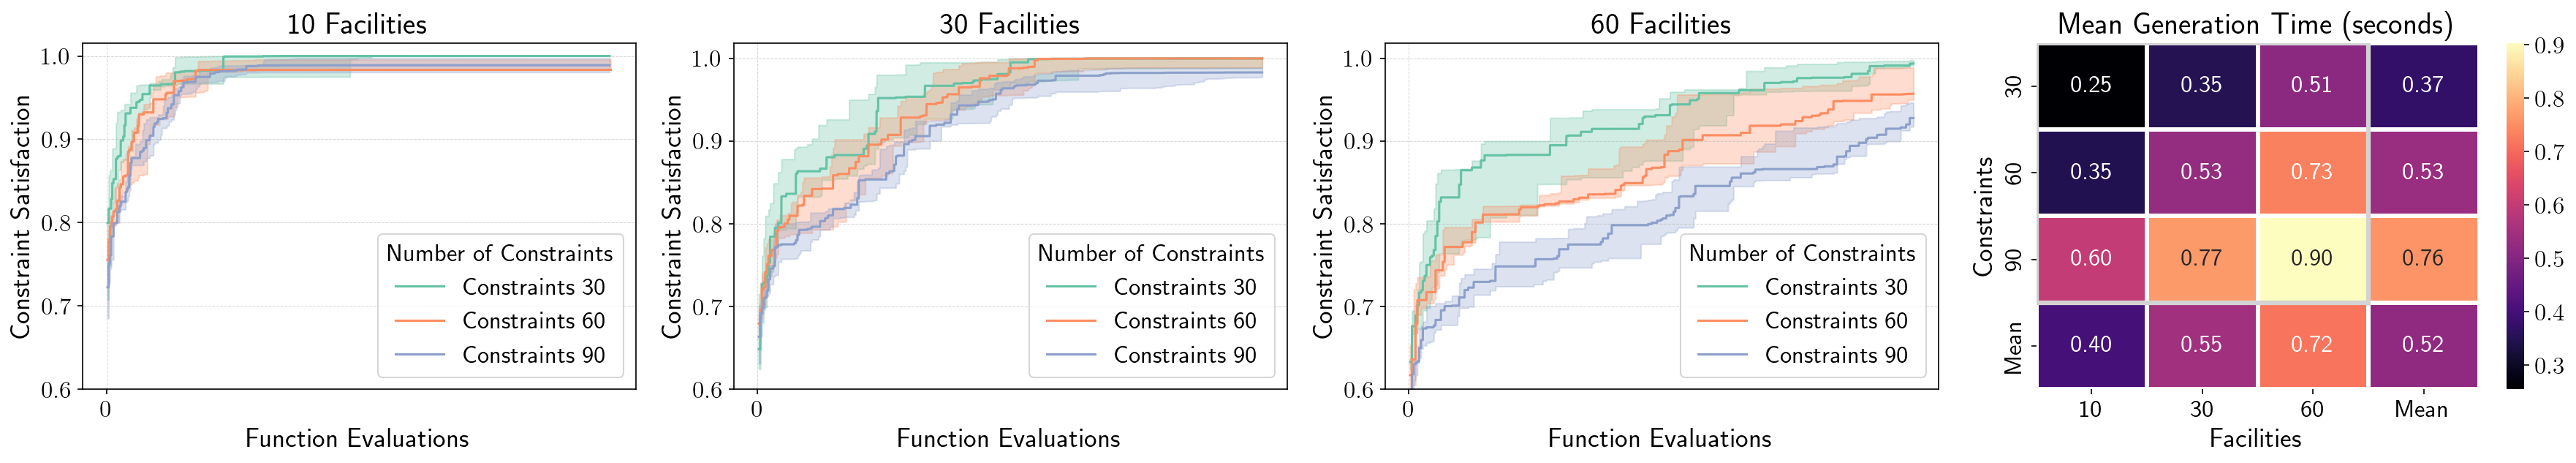

In [67]:
def create_heatmap(ax, stats, constraints, facilities):
    data = np.zeros((len(constraints) + 1, len(facilities) + 1))
    for i, constraint in enumerate(constraints):
        for j, facility in enumerate(facilities):
            key = f"{constraint}-{facility}"
            if key in stats:
                data[i, j] = stats[key][0]
    data[-1, :-1] = np.mean(data[:-1, :-1], axis=0)
    data[:-1, -1] = np.mean(data[:-1, :-1], axis=1)
    data[-1, -1] = np.mean(data)  # Mean of the entire data

    df = pd.DataFrame(data, index=constraints + ['Mean'], columns=facilities + ['Mean'])
    sns.heatmap(df, annot=True, fmt=".2f", cmap="magma", linewidths=2, linecolor='white', ax=ax)
    ax.add_patch(plt.Rectangle((0, 0), len(facilities), len(constraints), fill=False, edgecolor='lightgray', lw=3))
    ax.set_title('Mean Generation Time (seconds)')
    ax.set_xlabel('Facilities')
    ax.set_ylabel('Constraints')


# Creating a plot with 4 subplots in a single row
fig, axs = plt.subplots(1, 4, figsize=(24, 4.5),dpi=150)  # Adjust figsize as needed

# Plotting each subplot
plot_convergence(axs[0], 10, results)
plot_convergence(axs[1], 30, results)
plot_convergence(axs[2], 60, results)
create_heatmap(axs[3],stats, constraints, facilities)
plt.tight_layout()
plt.savefig("convergance.png")



In [66]:
seconds = 0.9*250*(20000/16)
#seconds = 0.25*250*1000*4
hours = (seconds/60)/60
days = hours/24
print(hours)
print(days)


78.125
3.2552083333333335


In [65]:
N = 60
4+np.floor(3*np.log(N))


16.0